# <center> Minsiscope Parameter Screen </center>
<center> Author: Nathaniel Nyema </center>

This notebook is meant to be used to screen parameters for micro-endoscope recordings. The other scripts included in this folder can be used to run the entire pipeline once these parameters have been finalized. Much of this has been adapted from sample notebooks made available by the CaIman developers.

In [7]:
#importing all necessary libraries
import pandas as pd
import cv2 as cv
from tifffile import imread, imsave
from skimage import exposure
from scipy.ndimage import median_filter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import imageio
from base64 import b64encode
from IPython.display import HTML
import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.source_extraction import cnmf as cnmf
from caiman.source_extraction.cnmf.online_cnmf import OnACID
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import inspect_correlation_pnr
from tqdm import tqdm
from pathlib import Path
import os
import logging

logging.basicConfig(format= "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s]"\
                                "[%(process)d] %(message)s",
                        level=logging.INFO)

In [8]:
#@figure settings
mpl.rcParams.update({
    'figure.subplot.wspace': .1,
    'figure.subplot.hspace': .1,
    'figure.figsize': (18, 13),
    'svg.fonttype':'none'
})

In [9]:
# enter the path to some sample data here

path = "/Volumes/Expansion/lois-lab/sample_data/ds/miniscope2022-08-26T00_02_22_ds.avi"
cap = cv.VideoCapture(path)
n_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
fr = cap.get(cv.CAP_PROP_FPS)
wd = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
ht = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
os.environ["SLURM_SUBMIT_DIR"] = Path(path).parent.as_posix()

print('# Frames: ', n_frames)
print('frame rate: ', fr)
print('dims: ', ht, 'x', wd)
print('duration : ', (n_frames/fr)/3600, 'hr')


# Frames:  181725
frame rate:  25.0
dims:  480 x 640
duration :  2.0191666666666666 hr


#### here we run motion correction

In [28]:
# settings for motion correction
mc_params = {
    "fnames": [path],
    "gSig_filt":  (3, 3),     # size of high pass spatial filtering, used in 1p data
    "max_shifts": (50, 50),  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
    "pw_rigid"  : False,       # flag for performing rigid or piecewise rigid motion correction (false for now as we want to asses rigid registration first)
    "border_nan"   : 'copy',
    "use_cuda"  : False,
    "splits_rig": int(n_frames/200),
}

opts = params.CNMFParams(params_dict = mc_params)

In [29]:
#setting up clusters for parallel processing
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

#create motion correction object and perform rigid motion correction
mc = MotionCorrect([path], dview=dview, **opts.get_group('motion'))
mc.motion_correct(save_movie=True)

31
CPU times: user 36.1 ms, sys: 698 ms, total: 734 ms
Wall time: 775 ms


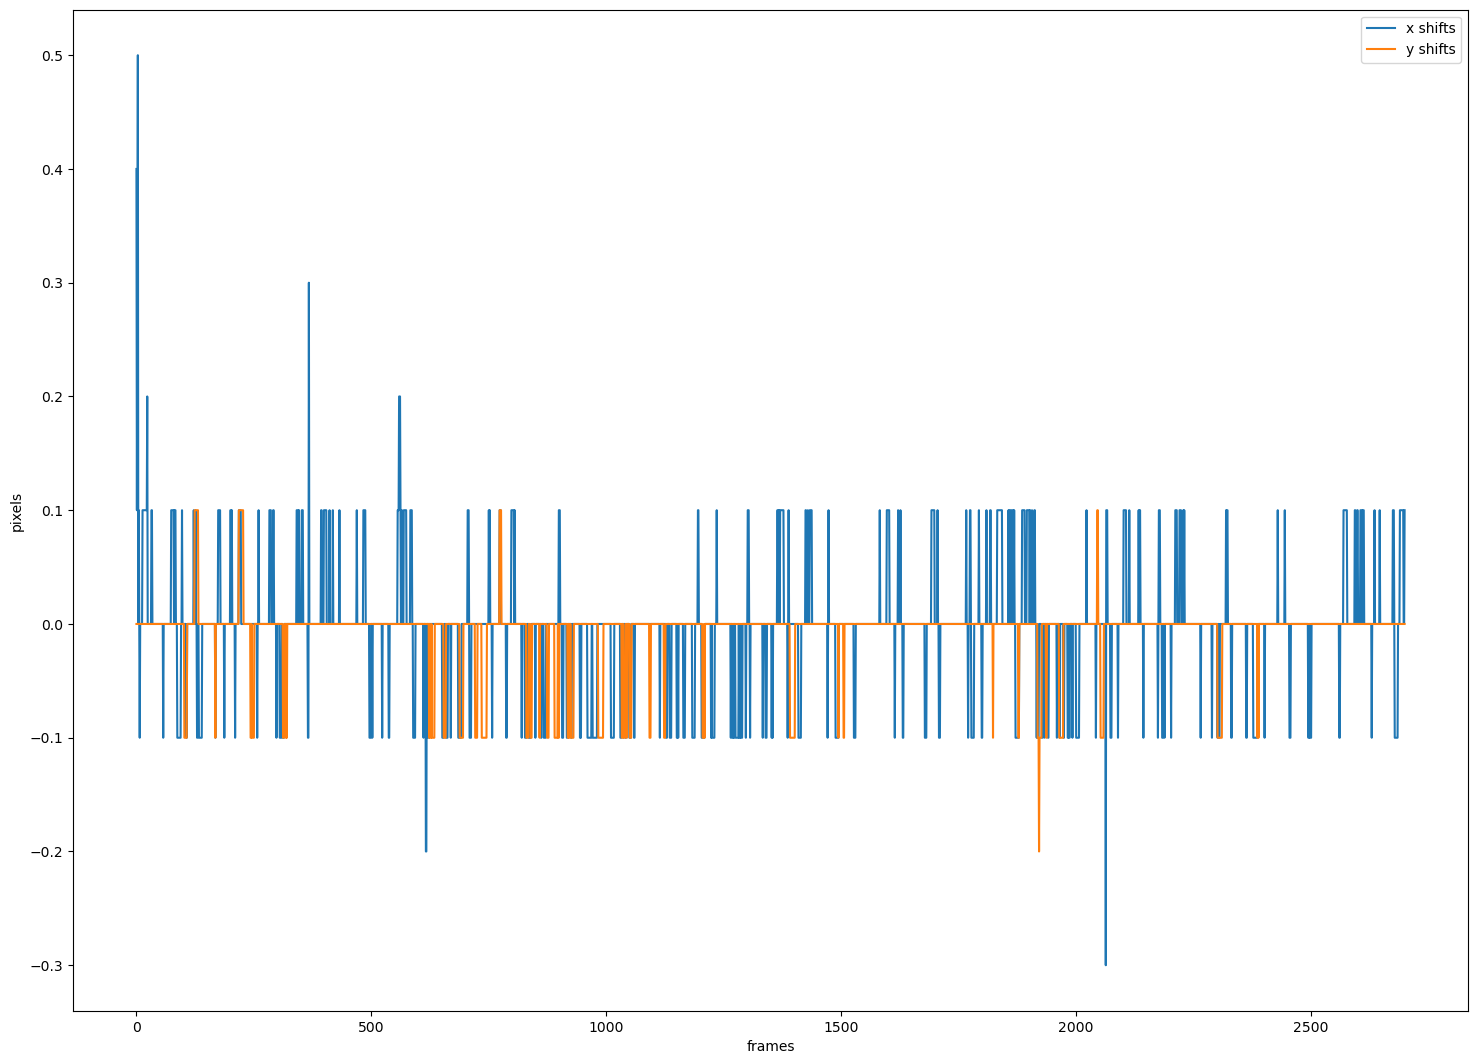

In [33]:
#@title plot shifts
plt.plot(np.array(mc.shifts_rig)[:,0], label = 'x shifts');
plt.plot(np.array(mc.shifts_rig)[:,1], label = 'y shifts');
plt.legend();
plt.xlabel('frames');
plt.ylabel('pixels');

### save motion corrected memmap
Once we've finished computing the shifts we need to save a memmory-mapped file which we'll use later to rsource extraction. We're first going to clear up some memmory because I had some issues running this on Colab when I didn't delete all of these lingering variables.

In [34]:
# clear up some memory
if 'c' in locals():del c
if 'cl' in locals(): del c1
if 'c2' in locals(): del c2
if 'data_url' in locals(): del data_url
if 'max_' in locals(): del max_
if 'min_' in locals(): del min_
if 'mp4' in locals(): del mp4

In [35]:
# save memory map file for structural channel
border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0 
fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                           border_to_0=border_to_0, dview=dview)

In [20]:
print(fname_new)

/central/groups/RaraeAves/nathaniel/miniscope_data/sample_data_fr_jiang/chunk0/shortened/ds/memmap__d1_480_d2_640_d3_1_order_C_frames_187_.mmap


## Source Extraction
---

In [36]:
#getting data
# fname_new = '/central/groups/RaraeAves/nathaniel/miniscope_data/sample_data_fr_jiang/chunk0/ds/memmap__d1_480_d2_640_d3_1_order_C_frames_2700_.mmap'
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F')

del Yr
del T

In [37]:
#stop and restart clusters to clear up memory
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

### Constrained Nonnegative Matrix Factorization (CNMF or CNMF-E)
Now that we have corrected for motion, we are faced with the problem of extracting calcium traces for each individual neuron in the recording. The CNMF is a quite standard framework for performing this task. The basic idea is we have this movie stored in memory as a 3-dimensional array where the first dimension is time (the frame in the recording) and the last 2 are space (pixels within a frame). Each element is the brightness of a pixel on a given frame. We can first flatten this array along the last 2 dimensions then transpose it to get a matrix of dimensions $d x T$ where $T$ is the number of frames and $d$ is the number of pixels in a frame. Lets call this matrix $Y$. Given this matrix we can now use some linear algebra to decompose it as follows:

$$Y = AC + B + E$$

There are of course many ways for $Y$ to be decomposed into such an equation. For our purposes we place a number of constraints in order to ensure the resulting terms on the right side of this equation are meaningful. Specifically we define $A$ to be a sparse matrix which represents spatial footprints of each neuron in the recording. I refrain from using the phrase ROI because neurons can overlap spatially and in this model we hope to demix any signals from such overlapping neurons. Every column in A corresponds to its own footprint and each row is a pixel.The values are weights for how involved a given pixel is in that footprint. $C$ in turn represents in theory the true calcium trace for each spatial footprint (neuron) over time, where each row is a footprint and each column is a frame. As such, $A$ has dimension $d x N$ where $N$ is the number of ROIs and $C$ is $N x T$.  Hopefully it's clear that if we take the matrix product of $A$ and $C$ we just get $M$ without any noise. The remaining structured, non-neuronal background noise is therefore captured by $B$. 

For miniscope recordings there is a great deal of such background noise which makes proper estimation of $B$ critical for reasonable signal extraction. In fact, the key innovations of the CNMF-E over the CNMF (what we've essentially described up to this point) are additional considerations for modeling background term $B$. 

In general, the actual optimization procedure is not super important for running the pipeline. There are a couple of features worth noting, though, that will help with setting parameters. 


In [10]:

# parameters for source extraction and deconvolution
gSig = [12, 12]        # gaussian width of a 2D gaussian kernel, which approximates a neuron
                                             # should be approximately (gSiz - 1)/4
gSiz = [36, 36]       # average diameter of a neuron, in general 4*gSig+1. CRUCIAL parameter for proper component detection.
min_pnr = 9        # minimum peak-to-noise ratio for identifying potential seeds for spatial components in the model
min_corr = .9     # minimum local correlation for identifying potential seeds for spatial components in the model
min_SNR = 3          # adaptive way to set threshold on the transient size
decay_time = 1.8     # this should be set to 1.8 for GCamp6s, but can be changed to 0.4 for faster indicators
                     # (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
p = 1                # characterizes the rise time of the calcium transient. this must be 2 for GCamp6s, 
                     # but it can be set to 1 for faster indicators
gnb = 0              # number of background components (rank) if positive,
                     # else exact ring model with following settings
                     #  gnb= 0: Return background as b and W
                     #  gnb=-1: Return full rank background B
                     #  gnb<-1: Don't return background
ssub = 1             # downsampling factor in space for initialization,
                     # increase if you have memory problems
                     # you can pass them here as boolean vectors
rval_thr = 0.8               # threshold on space consistency (if you lower more components
                             # will be accepted, potentially with worst quality)
merge_thr = .65              # merging threshold, max correlation allowed
K = None                     # upper bound on number of rois per patch
ssub_B = 4                   # additional downsampling factor in space for background
bord_px = 15                 # number of pixels on the border to exclude
ds_factor = 2                # spatial downsampling factor (during online processing)

gSig = list((np.array(gSig)/ds_factor).astype(int))
gSiz = list((np.array(gSiz)/ds_factor).astype(int))

rf = int(max(gSiz)*3)     # half-size of the patches in pixels. Should be at least 3 to 4 times larger than the expected neuron size 
stride = int(max(gSiz))   # amount of overlap between the patches in pixels

sniper_mode = False           # flag using a CNN to detect new neurons (o/w space correlation is used)
init_batch = 750              # number of frames for initialization (presumably from the first file)
expected_comps = 1000          # maximum number of expected components used for memory pre-allocation (exaggerate here)
dist_shape_update = False     # flag for updating shapes in a distributed way
min_num_trial = 3             # number of candidate components per frame     
epochs = 3                    # number of passes over the data
show_movie = False           # show the movie with the results as the data gets processed
use_corr_img = False          # flag for using the corr*pnr image when searching for new neurons (otherwise residual)
                                # i wasn't getting many additional components after initialization when this was true so using false now
stop_detection = True

opts = params.CNMFParams(params_dict = {
                                      'fnames': [path],
                                      'fr': fr,
                                      'decay_time': decay_time,
                                      'method_init': 'corr_pnr',
                                      'gSig': gSig,
                                      'gSiz': gSiz,
                                      'rf': rf,
                                      'stride': stride,
                                      'p': p,
                                      'nb': gnb,
                                      'ssub': ssub,
                                      'min_SNR': min_SNR,
                                      'min_pnr': min_pnr,
                                      'min_corr': min_corr,
                                      'bas_nonneg': False,
                                      'center_psf': True,
                                      'rval_thr': rval_thr,
                                      'only_init': True,
                                      'merge_thr': merge_thr,
                                      'K': K,
                                      'ssub_B': ssub_B,
                                      'border_pix': bord_px,
                                      'use_cnn':False,
                                      'epochs': epochs,
                                      'gSig_filt': (3, 3) ,
                                      'max_shifts_online': 20,
                                      'motion_correct': True,
                                      'init_batch': init_batch,
                                      'init_method': 'cnmf',
                                      'normalize_init': False,
                                      'update_freq': 200,
                                      'expected_comps': expected_comps,
                                      'sniper_mode': sniper_mode, 
                                      'dist_shape_update' : dist_shape_update,
                                      'min_num_trial': min_num_trial,
                                      'use_corr_img': use_corr_img,
                                      'show_movie': show_movie,
                                      'stop_detection': stop_detection, 
                                      'verbosity': True,
                                      'ds_factor': ds_factor,
    
})

# save the parameters used
np.save("../opts.npy", opts.to_dict())

     1850654 [params.py:                 set():973][21422] Changing key fnames in group data from None to ['/Volumes/Expansion/lois-lab/sample_data/ds/miniscope2022-08-26T00_02_22_ds.avi']
     1850656 [params.py:                 set():973][21422] Changing key fr in group data from 30 to 25.0
     1850657 [params.py:                 set():973][21422] Changing key decay_time in group data from 0.4 to 1.8
     1850658 [params.py:                 set():973][21422] Changing key rf in group patch from None to 54
     1850660 [params.py:                 set():973][21422] Changing key stride in group patch from None to 18
     1850661 [params.py:                 set():973][21422] Changing key border_pix in group patch from 0 to 15
     1850663 [params.py:                 set():973][21422] Changing key p in group preprocess from 2 to 1
     1850664 [params.py:                 set():973][21422] Changing key method_init in group init from greedy_roi to corr_pnr
     1850666 [params.py:          

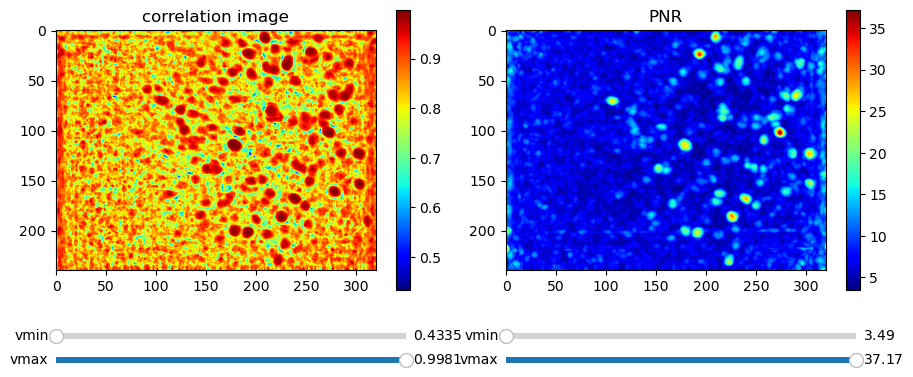

In [54]:
## compute peak to noise ratio to determine appropriate parameters min_pnr, min_corr and gSig
# note min_pnr and min_corr are just thresholds that will be set to determine where to initialize
# the algorithm. these thresholds should be set with the below images in mind. however keep in mind
# the below images depend strongly on gsig because gsig determines how much spatial filtering is performed
# before creating the below images. so if the pnr map looks very noisy try adjusting gsig

cn, pnr = cm.summary_images.correlation_pnr(images[:init_batch, ::ds_factor, ::ds_factor], gSig= gSig[0], swap_dim=False) 
inspect_correlation_pnr(cn, pnr)

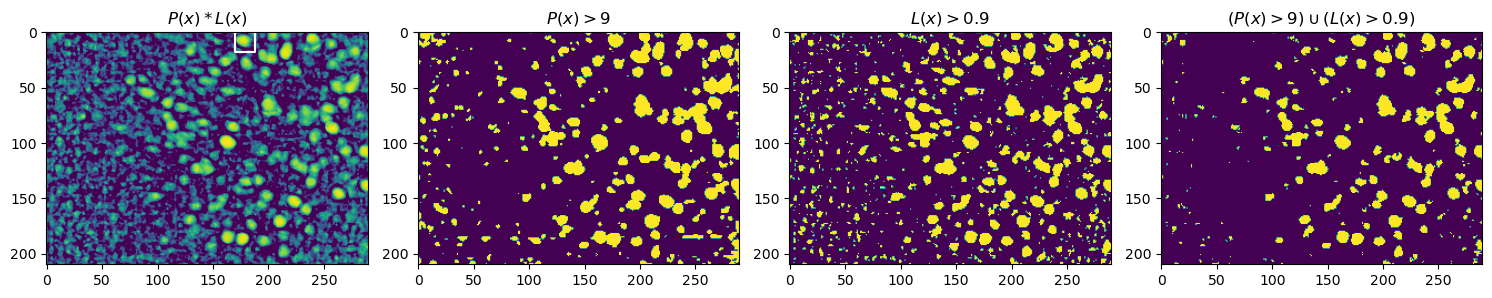

In [72]:
# test out the thresholds
fig, ax = plt.subplots(1,4, figsize = (15,3))
ax[0].imshow((cn)[bord_px:-bord_px,bord_px:-bord_px],  vmin = .8, vmax=1)


orig = [170,0]
dxy = np.array([[0      , 0      ],
                [gSiz[0], 0      ],
                [gSiz[0], gSiz[1]],
                [0      , gSiz[1]],
                [0      , 0      ]])

box = np.tile(orig, (5,1)) + dxy
ax[0].plot(box[:,0], box[:,1], c = 'w')
ax[0].set_title(r'$P(x)*L(x)$')
ax[1].imshow((pnr>min_pnr)[bord_px:-bord_px,bord_px:-bord_px])
ax[1].set_title(fr'$P(x)>{min_pnr}$')
ax[2].imshow((cn>min_corr)[bord_px:-bord_px,bord_px:-bord_px])
ax[2].set_title(fr'$L(x)>{min_corr}$')
ax[3].imshow(((pnr>min_pnr) & (cn>min_corr))[bord_px:-bord_px,bord_px:-bord_px])
ax[3].set_title(fr'$(P(x)>{min_pnr}) \cup (L(x)>{min_corr})$')
fig.tight_layout(pad = 1.)

In [11]:
#stop and restart clusters to clear up memory
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)
cnm = OnACID(params=opts, dview=dview)

In [12]:
%%time
cnm.fit_online()

     1916451 [movies.py:      extract_shifts():358][21422] Movie average is negative. Removing 1st percentile.
     1918824 [movies.py:      extract_shifts():358][21422] Movie average is negative. Removing 1st percentile.
     1921278 [movies.py:      extract_shifts():358][21422] Movie average is negative. Removing 1st percentile.
     1923141 [online_cnmf.py:   initialize_online():968][21422] Frame size:(240, 320)
     1923560 [params.py:                 set():973][21422] Changing key n_processes in group patch from 1 to 7
     1924815 [cnmf.py:                 fit():463][21422] (750, 240, 320)
     1924815 [cnmf.py:                 fit():480][21422] Using 7 processes
     1924816 [params.py:                 set():973][21422] Changing key n_pixels_per_process in group preprocess from None to 3778
     1924817 [params.py:                 set():973][21422] Changing key n_pixels_per_process in group spatial from None to 3778
     1924817 [cnmf.py:                 fit():491][21422] using 

cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes/Expansion/lois-lab/sample_data/ds
cluster temporary folder: /Volumes

ib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/nathanielnyema/opt/anaconda3/envs/caiman/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/Users/nathanielnyema/opt/anaconda3/envs/caiman/lib/python3.10/site-packages/caiman/source_extraction/cnmf/online_cnmf.py", line 2620, in inv_mat_vec
    return np.linalg.solve(A[0], A[1])
  File "<__array_function__ internals>", line 180, in solve
  File "/Users/nathanielnyema/opt/anaconda3/envs/caiman/lib/python3.10/site-packages/numpy/linalg/linalg.py", line 393, in solve
    r = gufunc(a, b, signature=signature, extobj=extobj)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
#view the initial contours to see if we need to change any parameters
cnm.estimates.plot_contours(img=pnr*cn);

In [ ]:
Cn = cm.load(fname_new).local_correlations()
cnm.estimates.plot_contours(img=Cn);

### visualize some of the raw traces

In [ ]:
cnm.estimates.dims=cnm.dims
cnm.estimates.view_components(img=Cn,idx=[3]);

In [9]:
min_SNR = 2           # adaptive way to set threshold on the transient size
r_values_min = 0.8    # threshold on space consistency (if you lower more components
                      # will be accepted, potentially with worst quality)
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': r_values_min,
                           'use_cnn': False})

cnm.estimates.evaluate_components(images, cnm.params, dview=dview)
cnm.estimates.plot_contours(img=pnr*cn, idx=cnm.estimates.idx_components);
cnm.estimates.nb_view_components(img=pnr*cn, idx=cnm.estimates.idx_components);

NameError: name 'cnm' is not defined